### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                                  # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.vision.all import *                         # Getting all the Libraries.
from fastai.callback.hook import *
#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**GETTING THE DATASET:**
- I will download a sample of **MNIST**.

In [6]:
#@ GETTING THE DATA: 
path = untar_data(URLs.MNIST_SAMPLE)                    # Path to the Dataset. 
path.ls()                                               # Inspecting Items.

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

### **FEATURE ENGINEERING:**
- **Feature Engineering** is the process of creating a new transformations of the input data in order to make it easier to model. 

In [7]:
#@ CREATING A MATRIX: AN EXAMPLE: 
top_edge = tensor([[-1, -1, -1], 
                   [ 0,  0,  0], 
                   [ 1,  1,  1]]).float()               # Initializing a Kernel. 

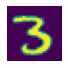

In [8]:
#@ GETTING AN IMAGE: 
im3 = Image.open(path/"train"/"3"/"12.png")             # Getting an Image. 
show_image(im3);                                        # Inspecting the Image. 

In [9]:
#@ WORKING WITH IMAGE: 
im3_t = tensor(im3)                                      # Converting into Tensor. 
print(im3_t[0:3, 0:3] * top_edge)                        # Initializing Multiplications. 
print((im3_t[0:3, 0:3] * top_edge).sum())                # Getting Sum of Tensors. 

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor(0.)


**Note:**
- It presents that all the pixels in top left corner are white. I will pick a couple of spots now. 

In [10]:
#@ INSPECTING PIXELS OF IMAGES: 
df = pd.DataFrame(im3_t[:10, :20])                        # Initializing a DataFrame. 
df.style.set_properties(
    **{"font-size":"6pt"}).background_gradient("Greys")   # Inspecting Pixels. 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [11]:
#@ GETTING MULTIPLICATION: 
print((im3_t[4:7, 6:9]*top_edge).sum())                    # Inspecting Multiplication. 
print((im3_t[7:10, 17:20]*top_edge).sum())                 # Inspecting Multiplication. 

tensor(762.)
tensor(-29.)


In [12]:
#@ CREATING A FUNCTION: 
def apply_kernel(row, col, kernel):                        # Defining a Function. 
    return (im3_t[row-1:row+2,col-1:col+2]*kernel).sum()   # Initializing Multiplication. 
apply_kernel(5, 7, top_edge)                               # Implementation. 

tensor(762.)

### **CONVOLUTIONAL KERNEL:**
- **Convolution** is simply an elementwise multiplication and addition. 

In [13]:
#@ INITIALIZING GRID OF COORDINATES: NESTED LIST COMPREHENSIONS: 
[[(i, j) for j in range(1,5)] for i in range(1,5)] 

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

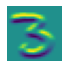

In [14]:
#@ IMPLEMENTATION OF KERNEL: TOP EDGES: 
rng = range(1, 27)                                               # Initialization. 
top_edge3 = tensor([[apply_kernel(i,j,top_edge
                                  ) for j in rng] for i in rng]) # Implementation of Function. 
show_image(top_edge3);                                           # Inspection. 

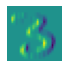

In [15]:
#@ IMPLEMENTATION OF KERNEL: LEFT EDGES:
left_edge = tensor([[-1, 1, 0], 
                   [-1, 1, 0], 
                   [-1, 1, 0]]).float()                          # Initializing a Kernel. 
left_edge3 =tensor([[apply_kernel(i,j,left_edge
                                  ) for j in rng] for i in rng]) # Implementation of Function. 
show_image(left_edge3);                                          # Inspection. 

In [16]:
#@ CREATING DIAGONAL KERNELS: 
diag1_edge = tensor([[ 0, -1,  1], 
                     [-1,  1,  0], 
                     [ 1,  0,  0]]).float()                      # Initializing a Diagonal Kernel. 
diag2_edge = tensor([[ 1, -1,  0],
                     [ 0,  1, -1], 
                     [ 0,  0,  1]]).float()                      # Initializing a Diagonal Kernel. 
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, 
                            diag2_edge])                         # Stacking Edge Kernels. 
edge_kernels.shape                                               # Inspecting the Shape. 

torch.Size([4, 3, 3])

In [17]:
#@ CREATING DATALOADER AND DATABLOCK: 
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),   # Initializing Data Block. 
                  get_items=get_image_files,                     # Getting Image Files. 
                  splitter=GrandparentSplitter(),                # Splitting the Data. 
                  get_y=parent_label)                            # Getting Labels. 
dls = mnist.dataloaders(path)                                    # Initializing DataLoaders. 
xb, yb = first(dls.valid)                                        # Getting a Batch. 
xb.shape, yb.shape                                               # Inspecting Shape. 

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [18]:
#@ MOVING DATA TO CPU: 
xb, yb = to_cpu(xb), to_cpu(yb)

**Note:**
- A **channel** is a single basic color in an image. For a regular full color images, there are three channels : red, green and blue. **Kernels** passed to convolutions need to be rank 4 tensors. 

In [19]:
#@ INSERTING A UNIT AXIS: 
edge_kernels.shape, edge_kernels.unsqueeze(1).shape              # Inserting a Unit Axis. 

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [20]:
#@ IMPLEMENTATION OF CONVOLUTIONS: 
edge_kernels = edge_kernels.unsqueeze(1)                         # Inserting a Unit Axis. 
batch_features = F.conv2d(xb, edge_kernels)                      # Implementation of Convolutions. 
batch_features.shape                                             # Inspecting Shape. 

torch.Size([64, 4, 26, 26])

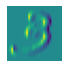

In [21]:
#@ INSPECTING AN IMAGE: 
show_image(batch_features[0, 0]);

**STRIDES AND PADDING:**
- If we add a kernel of size ks by ks with ks an odd number then the necessary padding on each side to keep the same shape is ks//2. The general formula for each dimension is (n + 2*padding - kernel size) // stride + 1.  

### **CONVOLUTIONAL NEURAL NETWORK:**

In [22]:
#@ INITIALIIZNG A BASIC NEURAL NETWORK: 
simple_net = nn.Sequential(nn.Linear(28*28, 30),                # Initializing Linear Layer. 
                           nn.ReLU(),                           # Initializing RELU Activation. 
                           nn.Linear(30, 1))                    # Initializing Linear Layer. 
simple_net                                                      # Inspecting Neural Network. 

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [23]:
#@ INITIALIZING A CONVOLUTIONAL NEURAL NETWORK: 
broken_cnn = sequential(nn.Conv2d(1, 30, kernel_size=3, padding=1),    # Initializing Convolutional Layer. 
                        nn.ReLU(),                                     # Initializing RELU. 
                        nn.Conv2d(30, 1, kernel_size=3, padding=1))    # Initializing Convolutional Layer. 
broken_cnn(xb).shape                                                   # Inspecting Shape. 

torch.Size([64, 1, 28, 28])

**CHANNELS AND FEATURES:**
- **Channels** and **Features** are largely used interchangeably and refer to the size of the second axis of a weight matrix which is the number of activations per grid cell after a convolution. **Channels** refer to the input data i.e colors or activations inside the network. Using a stride 2 convolution often increases the number of **Features** at the same time because the number of activations in the activation map decrease by the factor of 4. 

In [24]:
#@ DEFINING FUNCTION FOR CONVOLUTIONS: 
def conv(ni, nf, ks=3, act=True):                                      # Defining Convolutions. 
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)   # Initializing Convolutional Layer. 
    if act: res = nn.Sequential(res, nn.ReLU())                        # Initializing Sequential Layer. 
    return res

#@ BUILDING A SIMPLE CONVOLUTIONAL NEURAL NETWORK: 28X28 IMAGE: 
simple_cnn = sequential(conv(1, 4),                                    # Implementation of Convolutions: 14X14
                        conv(4, 8),                                    # Implementation of Convolutions:  7X7
                        conv(8, 16),                                   # Implementation of Convolutions:  4X4
                        conv(16, 32),                                  # Implementation of Convolutions:  2X2
                        conv(32, 2, act=False),                        # Implementation of Convolutions:  1X1
                        Flatten())                                     # Initializing Flatten Layer. 
simple_cnn(xb).shape                                                   # Inspecting the Shape. 

torch.Size([64, 2])

In [25]:
#@ CREATING LEARNER: 
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, 
                metrics=accuracy)                                      # Initializing Learner. 
learn.fit_one_cycle(2, 0.01)                                           # Training the Learner. 

epoch,train_loss,valid_loss,accuracy,time
0,0.061607,0.034631,0.988224,00:16
1,0.023813,0.023636,0.991659,00:16


**CONVOLUTION ARITHMETIC:**

In [26]:
#@ INSPECTING FIRST LAYER: 
m = learn.model[0]                           # Getting First Layer. 
m                                            # Inspection. 

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [27]:
#@ INSPECTING WEIGHT OF LAYER: 
print(m[0].weight.shape)                     # Inspecting Weights. 
print(m[0].bias.shape)                       # Inspecting Bias. 

torch.Size([4, 1, 3, 3])
torch.Size([4])


**RECEPTIVE FIELDS:**
- The **Receptive Field** is the area of an image that is involved in the calculation of a layer. In the deeper layers of network, we have semantically rich features, corresponding to larger **Receptive Fields**. 

### **CONVOLUTIONS AND COLOR IMAGES:**
- A color picture is a rank 3 tensor. 

torch.Size([3, 4000, 6000])


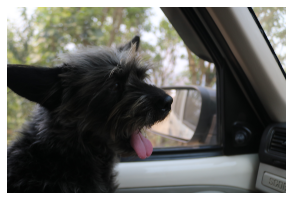

In [28]:
#@ GETTING A COLOR IMAGE: 
im = image2tensor(Image.open("/content/Bal.JPG"))           # Getting an Image. 
print(im.shape)                                             # Inspecting Shape. 
show_image(im);                                             # Inspecting Image. 

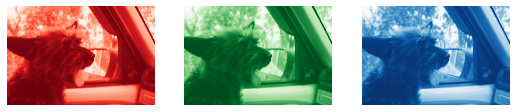

In [29]:
#@ INSPECTING COLOR CHANNELS: 
_, axs = subplots(1, 3)                                             # Initialization. 
for dog, ax, color in zip(im, axs, ("Reds", "Greens", "Blues")):      
    show_image(255-dog, ax=ax, cmap=color)                          # Inspecting Images. 

**IMPROVING TRAINING STABILITY:**

In [34]:
#@ GETTING THE DATASET: 
path = untar_data(URLs.MNIST)                                   # Path to the Dataset. 
path.ls()                                                       # Inspecting the Dataset. 

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

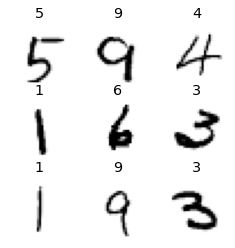

In [35]:
#@ FUNCTION FOR GETTING DATALOADERS: 
def get_dls(bs=64):                                             # Defining Function. 
    return DataBlock(                                           # Initializing DataBlock. 
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),     # Initializing Transformation Blocks. 
        get_items=get_image_files,                              # Getting Image Files. 
        splitter=GrandparentSplitter("training", "testing"),    # Splitting the Dataset. 
        get_y=parent_label,                                     # Getting Labels. 
        batch_tfms=Normalize()).dataloaders(path, bs=bs)        # Initializing DataLoaders.

#@ INITIALIZING DATALOADERS: 
dls = get_dls()                                                 # Implementation of Function. 
dls.show_batch(max_n=9, figsize=(4, 4))                         # Inspecting Batch of Data. 

In [36]:
#@ DEFINING FUNCTION FOR CONVOLUTIONS: BASELINE MODEL: 
def conv(ni, nf, ks=3, act=True):                                      # Defining Convolutions. 
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)   # Initializing Convolutional Layer. 
    if act: res = nn.Sequential(res, nn.ReLU())                        # Initializing Sequential Layer. 
    return res

#@ BUILDING A SIMPLE CONVOLUTIONAL NEURAL NETWORK: 28X28 IMAGE: 
def simple_cnn():
    return sequential(
        conv(1, 8, ks=5),                                              # Implementation of Convolutions: 14X14
        conv(8, 16),                                                   # Implementation of Convolutions:  7X7
        conv(16, 32),                                                  # Implementation of Convolutions:  4X4
        conv(32, 64),                                                  # Implementation of Convolutions:  2X2
        conv(64, 10, act=False),                                       # Implementation of Convolutions:  1X1
        Flatten())                                                     # Initializing Flatten Layer. 

**Note:**
- **Activation Stats** callback records mean, standard deviation and histogram of activations of every trainable layer.

In [37]:
#@ FUNCTION FOR TRAINING THE MODEL: 
def fit(epochs=1):                                                     # Function for Training. 
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,      # Initializing Leaner. 
                    metrics=accuracy,                                  # Initializing Metrics. 
                    cbs=ActivationStats(with_hist=True))               # Initializing Activation Stats Callbacks. 
    learn.fit(epochs, 0.06)                                            # Training the Learner. 
    return learn
learn = fit()                                                          # Implementation of Function. 

epoch,train_loss,valid_loss,accuracy,time
0,2.306366,2.307782,0.095800,01:24


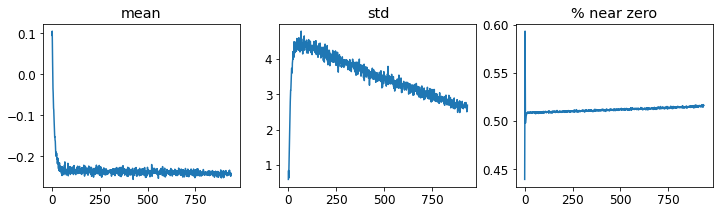

In [38]:
#@ INSPECTING ACTIVATIONS: FIRST LAYER: 
learn.activation_stats.plot_layer_stats(0)

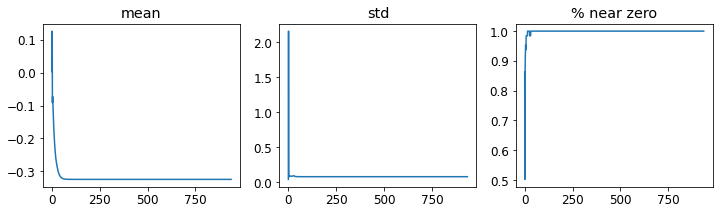

In [39]:
#@ INSPECTING ACTIVATIONS: FINAL LAYERS: 
learn.activation_stats.plot_layer_stats(-2)

**INCREASING BATCH SIZE:**
- Larger batches have gradients that are more accurate since they are calculated from more data. But larger batch size means fewer batches per epoch which means fewer opportunities for the model to update weights. 

In [40]:
#@ INCREASING BATCH SIZE: 
dls = get_dls(512)                                  # Initializing Data Loaders. 
learn = fit()                                       # Training the Learner. 

epoch,train_loss,valid_loss,accuracy,time
0,0.406066,0.268763,0.915600,01:13


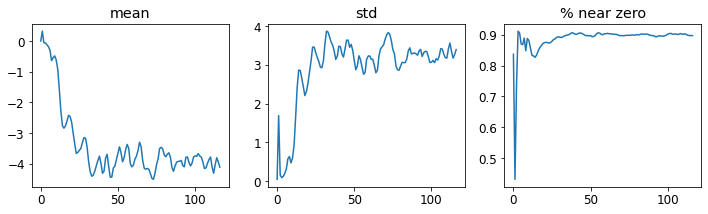

In [41]:
#@ INSPECTING ACTIVATIONS: FINAL LAYERS: 
learn.activation_stats.plot_layer_stats(-2)

**1 CYCLE TRAINING:**
- **1 Cycle Training** is a combination of warmup and annealing. **Warmup** is the one where learning rate grows from the minimum value to the maximum value and **Annealing** is the one where it decreases back to the minimum value. 

In [42]:
#@ TRAINING THE MODEL USING 1CYCLE TRAINING: 
def fit(epochs=1, lr=0.06):                                         # Defining the Function for Training. 
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,   # Initializing Learner and Loss Function. 
                    metrics=accuracy,                               # Initializing Accuracy Metrics. 
                    cbs=ActivationStats(with_hist=True))            # Initializing Callbacks. 
    learn.fit_one_cycle(epochs, lr)                                 # Initializing 1 Cycle Training. 
    return learn 
learn = fit()                                                       # Implementation of Function. 

epoch,train_loss,valid_loss,accuracy,time
0,0.214927,0.078700,0.975100,01:14


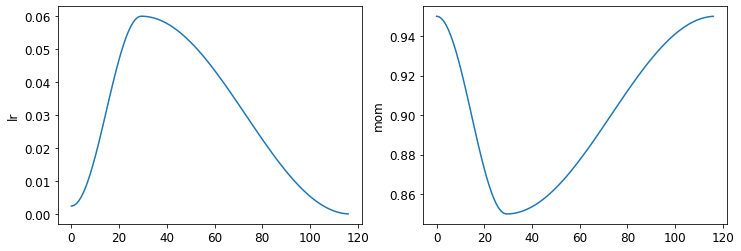

In [43]:
#@ INSPECTING LEARNING RATE AND MOMENTUM: 
learn.recorder.plot_sched()

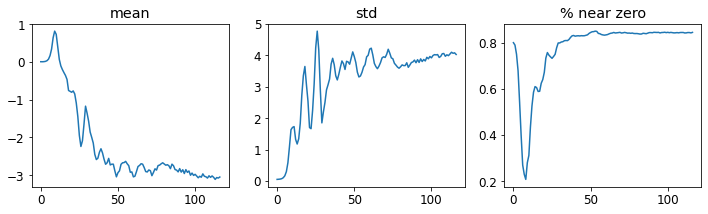

In [44]:
#@ INSPECTING ACTIVATIONS: FINAL LAYERS: 
learn.activation_stats.plot_layer_stats(-2)

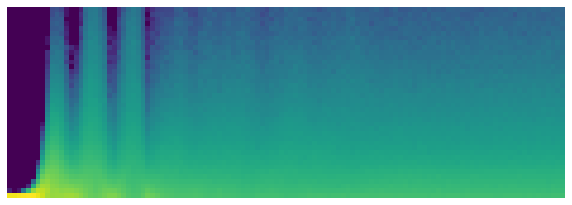

In [45]:
#@ INSPECTING TRAINING: 
learn.activation_stats.color_dim(-2)

**Note:**
- The bright yellow at the bottom represents the near zero activations. Then over the first few batches we see the number of nonzero activations exponentially increasing. But it goes too far and collapses! We see the dark blue return and the bottom becomes bright yellow again. It almost looks like training restarts from scratch. Then we see the activations increase again and collapse again. After repeating this a few times, eventually we see a spread of activations throughout the range. It is much better if training can be smooth from the start. The cycles of exponential increase and then collapse tend to result in a lot of near zero activations resulting in slow training and poor final results.